In [2]:
# Gerekli kütüphaneleri içe aktarma
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from google.colab import drive
drive.mount('/content/drive')
# Dosya yolu
file_path = '/content/finalemlak2.xlsx'
# Veri setini oku
df = pd.read_excel(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Bu liste modelde kullanmak istediğimiz sütunları içerir.
columns_to_use = ['price', 'district', 'county', 'residence', 'room', 'livingRoom', 'bathRoom',
 'age', 'heating', 'fuel', 'build', 'buildState', 'furnished', 'subCategory',
 'netSqm', 'grossSqm', 'bina_kat_sayisi', 'daire_kati', 'kuzey','guney','bati','dogu','goldeniz','bahceli','havuzlu']
df = df[columns_to_use].dropna() #nan varsa siler

In [4]:
#Kategorik sütunlar ve sayısal sütunlar belirlenir
categorical_features = ['district', 'county', 'residence', 'heating', 'fuel', 'build', 'buildState', 'furnished', 'subCategory']
numerical_features = [col for col in df.columns if col not in categorical_features + ['price']]  # df'deki tüm sütunlarda dolaş kategorik değişkenler ve 'price' hariç

# Bağımsız ve bağımlı değişkenler
X = df.drop('price', axis=1) #Diğer sütunlar bağımsız değişkenler
y = df['price'] #price

In [5]:
#Veriyi ön işleme için ColumnTransformer oluşturuluyor
preprocessor = ColumnTransformer([
    # Kategorik özellikler için OneHotEncoding uyguluyoruz
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),  # Kategorik sütunlar
    # Sayısal özellikler için StandardScaler (ölçeklendirme) uyguluyoruz
    ("num", StandardScaler(), numerical_features)  # Sayısal sütunlar
])

# Pipeline oluşturuluyor: Verinin ön işlenmesi ve modelin sırasıyla yapılması
pipeline = Pipeline([
    # İlk adım: Veri ön işleme
    ("preprocessor", preprocessor),  # Veriyi dönüştüren işleme (OneHotEncoding, StandardScaler)

    # İkinci adım: Modelin eğitilmesi
    ("regressor", LinearRegression())  # Linear Regression modelinin uygulanması
])

In [6]:
#Veriyi eğitim/test olarak böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
#test_size=0.2: Verinin %25'ini test seti, %75'ini eğitim seti olarak ayırır
#random_state=42: Veri bölünmesini tutarlı ve tekrarlanabilir hale getirir (aynı bölünme her seferinde elde edilir)

In [7]:
#Modeli eğit
pipeline.fit(X_train, y_train)
#Tahmin yap
y_pred = pipeline.predict(X_test)

In [8]:
# örnek için DataFrame oluştur
prediction_df = pd.DataFrame({
    "Gerçek Fiyat": y_test.values[:10],
    "Tahmin Edilen Fiyat": y_pred[:10]
})

# Virgülden sonra 2 basamakla göster
prediction_df = prediction_df.round(2)

print("Örnek Tahmin Sonucu:")
print(prediction_df)

Örnek Tahmin Sonucu:
   Gerçek Fiyat  Tahmin Edilen Fiyat
0       3350000           1819253.41
1       2750000           3174866.97
2       1250000          -1045252.98
3       1500000           2119382.92
4       2650000           2843609.63
5       2700000           9008916.99
6       2850000           3012784.64
7       4250000           3779401.26
8       8000000          15172924.66
9       8450000           9753476.88


In [9]:
#Performans metrikleri
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# MAE yüzdelik hata oranı
mean_actual = y_test.mean()
mae_percent = (mae / mean_actual) * 100

print("Performans Skorları:")
print("MSE  :", round(mse, 2))     #Ortalama kare hatası, büyükse büyük hata
print("MAE  :", round(mae, 2))     #Ortalama mutlak hata, küçükse doğru tahmin
print("MAE (%)   :", round(mae_percent, 2), "%")  # MAE yüzdelik hata oranı
print("RMSE :", round(rmse, 2))    #Kök ortalama kare hatası, küçükse doğru tahmin
print("R²   :", round(r2, 4))      #R-kare (modelin doğruluğu), 1'e yakınsa doğru tahmin


Performans Skorları:
MSE  : 18343194033637.85
MAE  : 2005957.53
MAE (%)   : 42.27 %
RMSE : 4282895.52
R²   : 0.3711


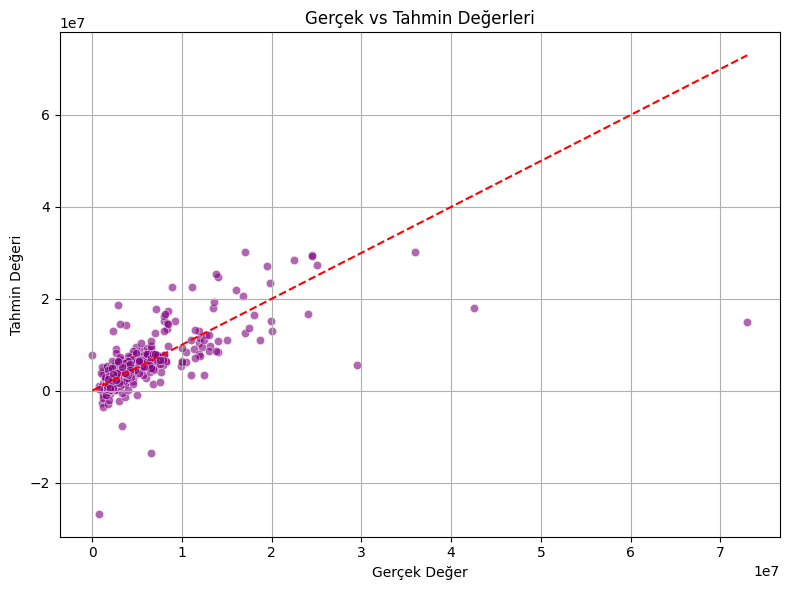

In [10]:
#Tahmin vs Gerçek değerleri karşılaştıran bir saçılım grafiği oluşturur
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Gerçek Değer")
plt.ylabel("Tahmin Değeri")
plt.title("Gerçek vs Tahmin Değerleri")
plt.grid(True)
plt.tight_layout()
plt.show()

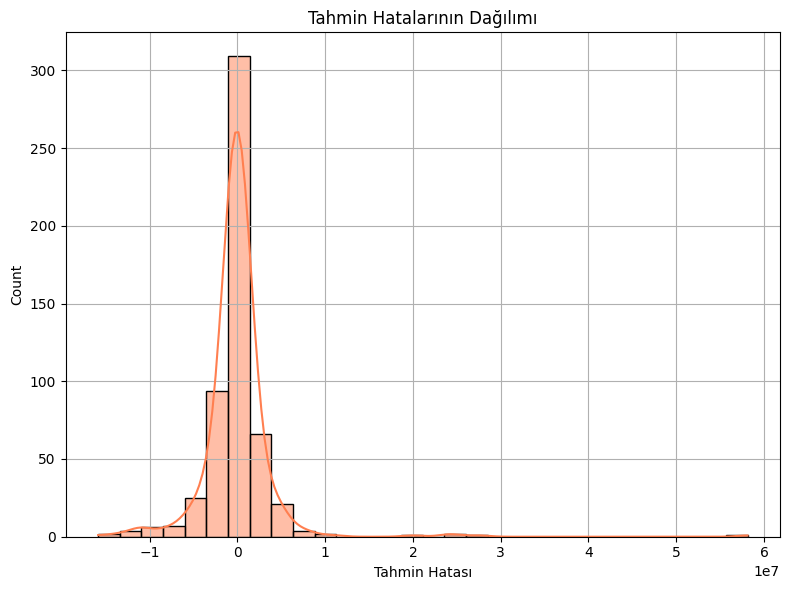

In [11]:
#Gerçek değerlerle tahmin değerleri arasındaki farkları (hataları) histogram olarak görselleştirir
errors = y_test - y_pred
plt.figure(figsize=(8,6))
sns.histplot(errors, bins=30, kde=True, color="coral")
plt.xlabel("Tahmin Hatası")
plt.title("Tahmin Hatalarının Dağılımı")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
import plotly.express as px
#treemap (ağaç haritası) grafiği, verilerdeki hiyerarşik yapıyı alan büyüklükleriyle ve renklerle görselleştirir.
fig = px.treemap(df,
                 path=['district', 'residence'],   #Hiyerarşi: önce ilçe, sonra konut tipi
                 values='price',                   #Her kutunun büyüklüğü: fiyat toplamına göre
                 color='price',                    #Renk: fiyatlara göre
                 color_continuous_scale='Viridis') # Renk geçiş skalası
fig.show()

<ipython-input-13-73500f1cb162>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




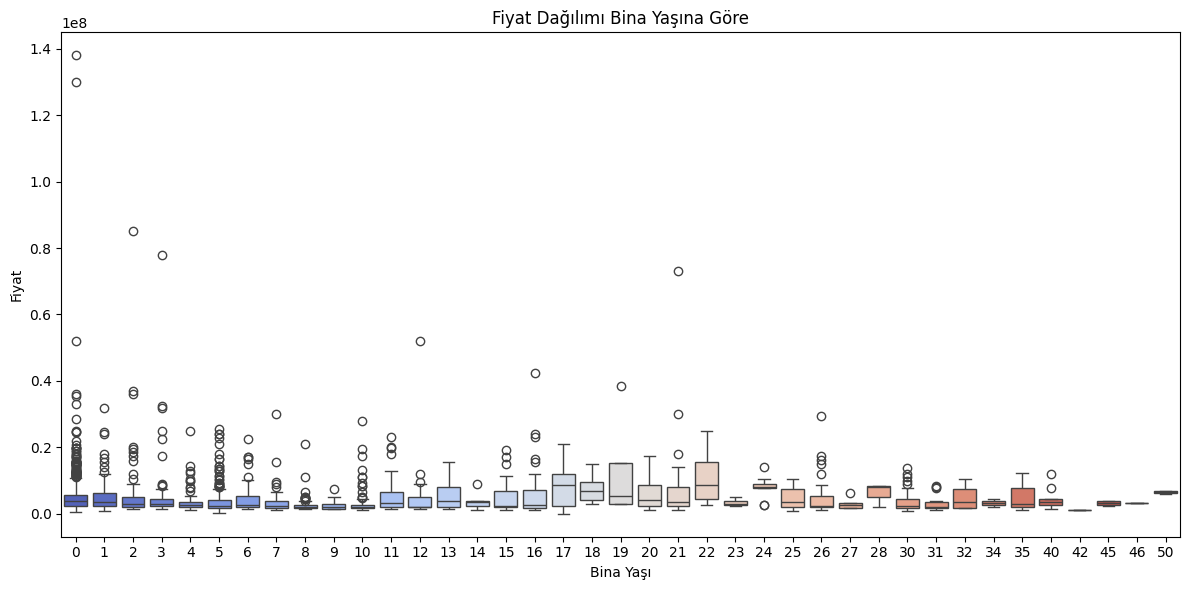

In [13]:
# Boxplot (Kutu Grafiği) oluşturuluyor:
# Bu grafik, 'age' (bina yaşı) sütunu ile 'price' (fiyat) arasındaki ilişkiyi görselleştirir.
plt.figure(figsize=(12,6))
sns.boxplot(x='age', y='price', data=df, palette='coolwarm')
plt.title("Fiyat Dağılımı Bina Yaşına Göre")
plt.xlabel("Bina Yaşı")
plt.ylabel("Fiyat")
plt.tight_layout()
plt.show()


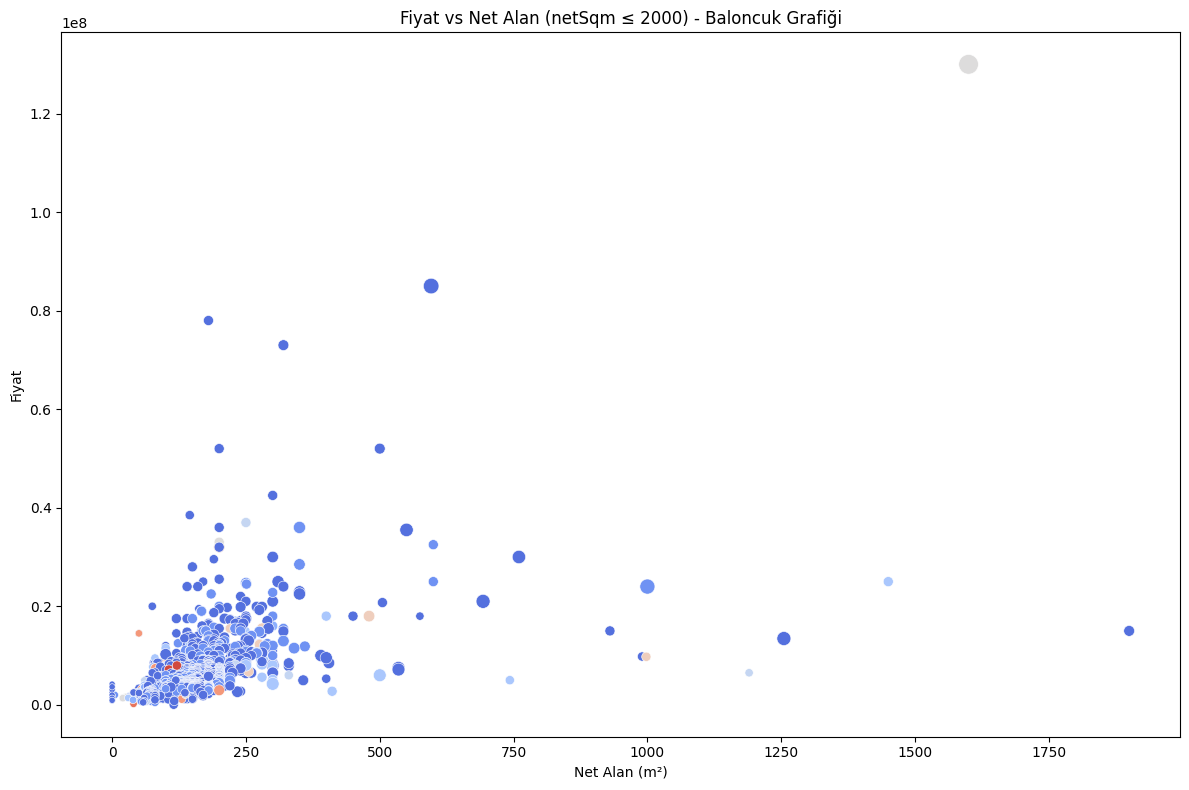

In [14]:
# netSqm'yi 2000'e kadar filtreleyelim
df_filtered = df[df['netSqm'] <= 2000]
# Scatterplot (baloncuk grafiği) ile Fiyat ve Net Alan arasındaki ilişkiyi görselleştiriyoruz
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='netSqm',
    y='price',
    size='room',
    hue='heating',
    sizes=(20, 200),
    palette='coolwarm',
    data=df_filtered,
    legend=False
)
plt.title("Fiyat vs Net Alan (netSqm ≤ 2000) - Baloncuk Grafiği")
plt.xlabel("Net Alan (m²)")
plt.ylabel("Fiyat")
plt.tight_layout()
plt.show()


In [15]:
#Optimizasyon
from statsmodels.stats.outliers_influence import variance_inflation_factor # VIF hesaplama fonksiyonu
from statsmodels.tools.tools import add_constant  # Sabit eklemek için
#VIF, bir bağımsız değişkenin diğer bağımsız değişkenlerle olan doğrusal ilişkisini ölçen bir metriktir.
# Yalnızca sayısal sütunlarla VIF hesaplamak daha doğru olur
numeric_cols = X.select_dtypes(include=[np.number]).columns  # Sayısal sütunları seçiyoruz
X_numeric = X[numeric_cols]  # Yalnızca sayısal verileri seçiyoruz

# Sabit (intercept) sütunu ekle
X_const = add_constant(X_numeric)  # Sabit sütunu ekliyoruz, bu regresyon modelinde genellikle bulunur

# VIF DataFrame oluştur
vif_data = pd.DataFrame()  # Yeni bir DataFrame oluşturuyoruz
vif_data["feature"] = X_numeric.columns  # Özellik isimlerini sütun olarak ekliyoruz
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X_numeric.columns))]
# VIF'yi her bir özellik için hesaplıyoruz. Sabit sütun olduğu için 1'den başlıyoruz

print("VIF Değerleri:")
print(vif_data)  # VIF değerlerini yazdırıyoruz
#VIF > 10: Çoklu doğrusal ilişki var, model güvenilirliği düşebilir. 10'dan büyük olanlar silinmeli


VIF Değerleri:
            feature       VIF
0              room  2.087331
1        livingRoom  1.217430
2          bathRoom  1.663131
3               age  1.174103
4            netSqm  1.800911
5          grossSqm  1.312808
6   bina_kat_sayisi  1.360233
7        daire_kati  1.508555
8             kuzey  1.154207
9             guney  1.103714
10             bati  1.224302
11             dogu  1.194643
12         goldeniz  1.043114
13          bahceli  1.056985
14          havuzlu  1.077167


In [16]:
#Optimizasyon -Aykırı değer temizliği

# 1. Çeyrek (Q1): Fiyatların %25'inin altında kaldığı değeri bulur
Q1 = y.quantile(0.25)
# 3. Çeyrek (Q3): Fiyatların %75'inin altında kaldığı değeri bulur
Q3 = y.quantile(0.75)
# IQR (Interquartile Range): Q3 ile Q1 arasındaki fark; yani ortadaki %50’lik veri aralığı
IQR = Q3 - Q1

# Aykırı olmayan veriler için maske oluşturulur:
# Fiyatı Q1 - 1.5*IQR'den büyük ve Q3 + 1.5*IQR'den küçük olan veriler geçerli kabul edilir
mask = (y >= Q1 - 1.5 * IQR) & (y <= Q3 + 1.5 * IQR)

#Sadece aykırı olmayan verileri koruyarak X ve y'yi filtrele
X = X[mask]
y = y[mask]

In [17]:
#Veriyi ön işleme için ColumnTransformer oluşturuluyor
preprocessor = ColumnTransformer([
    # Kategorik özellikler için OneHotEncoding uyguluyoruz
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),  # Kategorik sütunlar
    # Sayısal özellikler için StandardScaler (ölçeklendirme) uyguluyoruz
    ("num", StandardScaler(), numerical_features)  # Sayısal sütunlar
])

# Pipeline oluşturuluyor: Verinin ön işlenmesi ve modelin sırasıyla yapılması
pipeline = Pipeline([
    # İlk adım: Veri ön işleme
    ("preprocessor", preprocessor),  # Veriyi dönüştüren işleme (OneHotEncoding, StandardScaler)

    # İkinci adım: Modelin eğitilmesi
    ("regressor", LinearRegression())  # Linear Regression modelinin uygulanması
])

In [18]:
#Veriyi eğitim/test olarak böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
#test_size=0.2: Verinin %20'ini test seti, %80'ini eğitim seti olarak ayırır
#random_state=42: Veri bölünmesini tutarlı ve tekrarlanabilir hale getirir (aynı bölünme her seferinde elde edilir)

In [19]:
#Modeli eğit
pipeline.fit(X_train, y_train)
#Tahmin yap
y_pred = pipeline.predict(X_test)

In [20]:
#örnek için DataFrame oluştur
prediction_df = pd.DataFrame({
    "Gerçek Fiyat": y_test.values[:10],
    "Tahmin Edilen Fiyat": y_pred[:10]
})

# Virgülden sonra 2 basamakla göster
prediction_df = prediction_df.round(2)

print("Örnek Tahmin Sonucu:")
print(prediction_df)

Örnek Tahmin Sonucu:
   Gerçek Fiyat  Tahmin Edilen Fiyat
0       2000000           1448569.09
1       6150000           5252016.58
2       2850000           2778106.13
3       7000000           6272867.55
4       2095000           1998433.93
5       6400000           5324348.22
6       1950000           1973574.68
7       6150000           5763103.07
8       2950000           8068376.95
9       1550000           1800605.89


In [21]:
#Performans metrikleri
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# MAE yüzdelik hata oranı
mean_actual = y_test.mean()
mae_percent = (mae / mean_actual) * 100

print("Performans Skorları:")
print("MSE  :", round(mse, 2))     #Ortalama kare hatası, büyükse büyük hata
print("MAE  :", round(mae, 2))     #Ortalama mutlak hata, küçükse doğru tahmin
print("MAE (%)   :", round(mae_percent, 2), "%")  # MAE yüzdelik hata oranı
print("RMSE :", round(rmse, 2))    #Kök ortalama kare hatası, küçükse doğru tahmin
print("R²   :", round(r2, 4))      #R-kare (modelin doğruluğu), 1'e yakınsa doğru tahmin


Performans Skorları:
MSE  : 1506667077058.06
MAE  : 851943.13
MAE (%)   : 23.31 %
RMSE : 1227463.68
R²   : 0.6711


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import pandas as pd

#ID=864 price=2.6M tahmin=2.4M

sample_data = {
    'district': 'Neviye',
    'county': 'Arifiye',
    'residence': 'Daire',
    'heating': 'Yerden Isıtma',
    'fuel': 'Doğalgaz',
    'build': 'Betonarme',
    'buildState': 'Sıfır',
    'furnished': 'False',
    'subCategory': 'Daire',
    'netSqm': 95,
    'grossSqm': 110,
    'age': 0,
    'room': 2,
    'bathRoom': 2,
    'livingRoom': 1,
    'bahceli': 1,
    'bina_kat_sayisi': 3,
    'daire_kati': 2,
    'kuzey': 1,
    'guney': 1,
    'bati': 1,
    'dogu': 1,
    'goldeniz' : 1,
    'havuzlu': 0,
}

# DataFrame'e çevir
sample_df = pd.DataFrame([sample_data])

# Eğitim verisinden 'Daire' kategorisini al
subcat = sample_df['subCategory'].iloc[0]
train_group = df[df['subCategory'] == subcat]
X_train = train_group.drop(columns=["price"])
y_train = train_group["price"]

# Eksik sütunları tamamla
for col in X_train.columns:
    if col not in sample_df.columns:
        sample_df[col] = 'Hayır' if X_train[col].dtype == 'object' else 0

sample_df = sample_df[X_train.columns]

# Sütun türlerini ayır
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numeric_cols = X_train.select_dtypes(include='number').columns.tolist()

# Pipeline oluştur
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

# Eğit ve tahmin et
pipe.fit(X_train, y_train)
predicted_price = pipe.predict(sample_df)[0]

print(f"Bu örnek dairenin tahmini fiyatı: {round(predicted_price):,} TL")


Bu örnek dairenin tahmini fiyatı: 2,448,605 TL


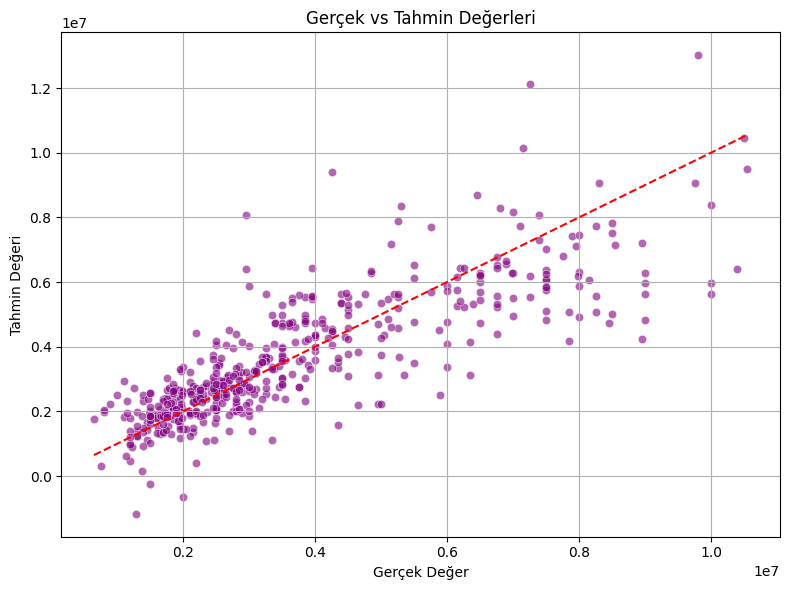

In [26]:
#Tahmin vs Gerçek değerleri karşılaştıran bir saçılım grafiği oluşturur
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Gerçek Değer")
plt.ylabel("Tahmin Değeri")
plt.title("Gerçek vs Tahmin Değerleri")
plt.grid(True)
plt.tight_layout()
plt.show()

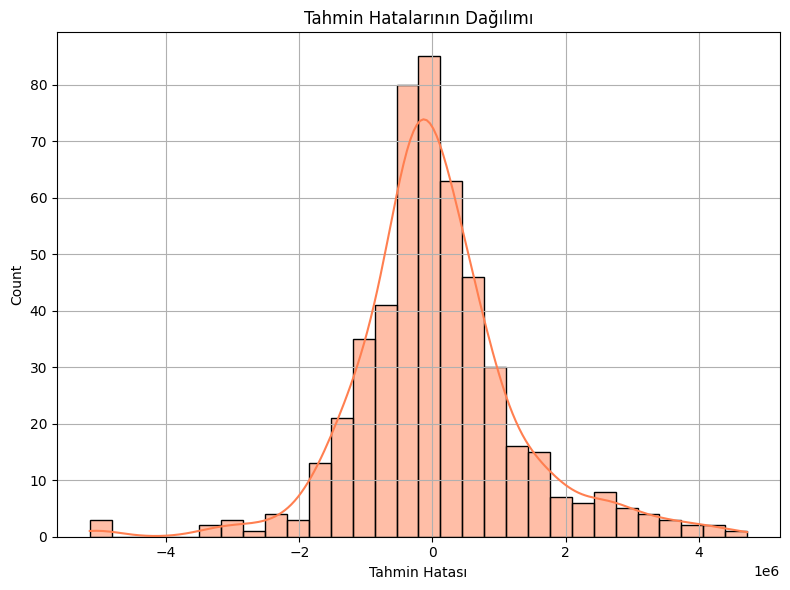

In [27]:
#Gerçek değerlerle tahmin değerleri arasındaki farkları (hataları) histogram olarak görselleştirir
errors = y_test - y_pred
plt.figure(figsize=(8,6))
sns.histplot(errors, bins=30, kde=True, color="coral")
plt.xlabel("Tahmin Hatası")
plt.title("Tahmin Hatalarının Dağılımı")
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
import plotly.express as px
#treemap (ağaç haritası) grafiği, verilerdeki hiyerarşik yapıyı alan büyüklükleriyle ve renklerle görselleştirir.
fig = px.treemap(df,
                 path=['district', 'residence'],   #Hiyerarşi: önce ilçe, sonra konut tipi
                 values='price',                   #Her kutunun büyüklüğü: fiyat toplamına göre
                 color='price',                    #Renk: fiyatlara göre
                 color_continuous_scale='Viridis') # Renk geçiş skalası
fig.show()

<ipython-input-29-73500f1cb162>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




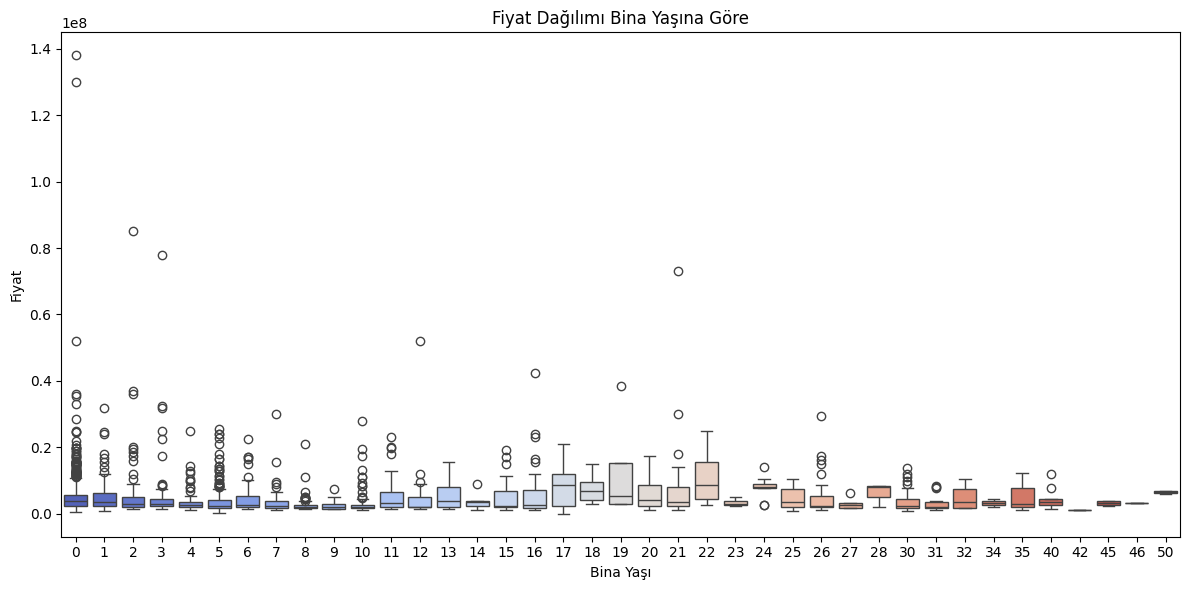

In [29]:
# Boxplot (Kutu Grafiği) oluşturuluyor:
# Bu grafik, 'age' (bina yaşı) sütunu ile 'price' (fiyat) arasındaki ilişkiyi görselleştirir.
plt.figure(figsize=(12,6))
sns.boxplot(x='age', y='price', data=df, palette='coolwarm')
plt.title("Fiyat Dağılımı Bina Yaşına Göre")
plt.xlabel("Bina Yaşı")
plt.ylabel("Fiyat")
plt.tight_layout()
plt.show()


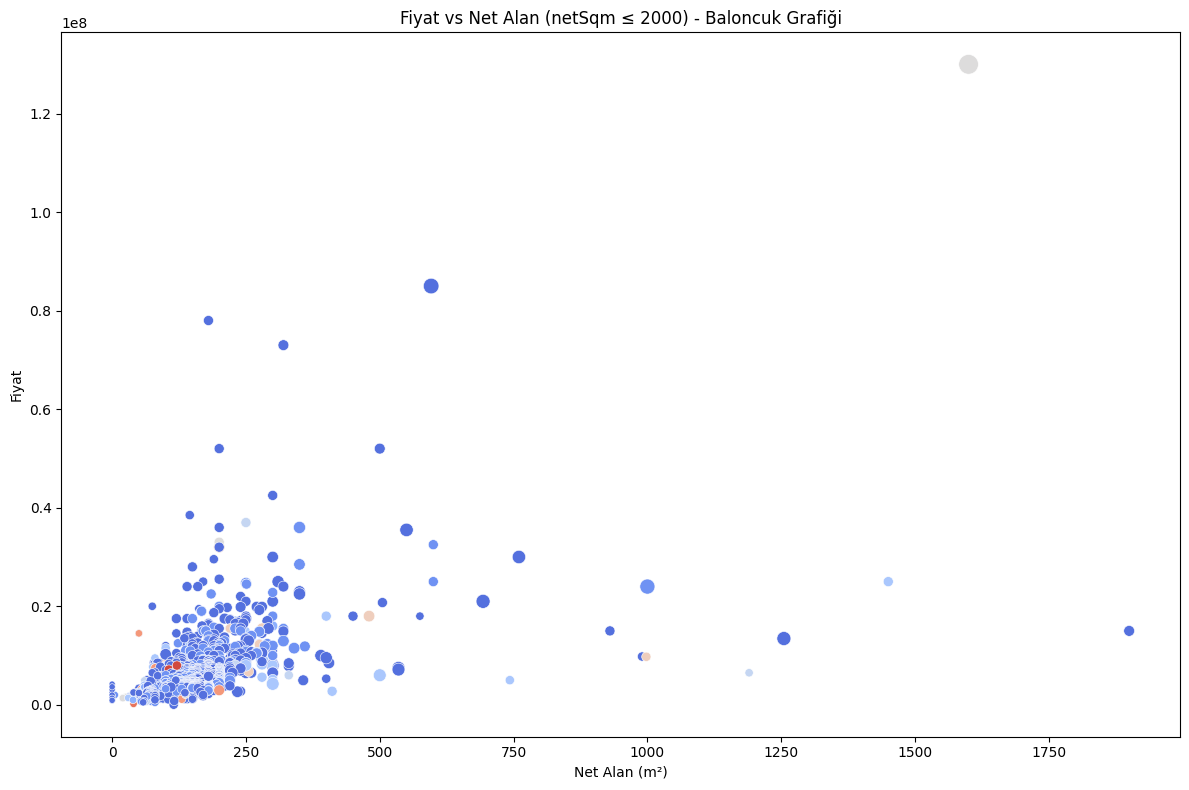

In [30]:
# netSqm'yi 2000'e kadar filtreleyelim
df_filtered = df[df['netSqm'] <= 2000]
# Scatterplot (baloncuk grafiği) ile Fiyat ve Net Alan arasındaki ilişkiyi görselleştiriyoruz
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='netSqm',
    y='price',
    size='room',
    hue='heating',
    sizes=(20, 200),
    palette='coolwarm',
    data=df_filtered,
    legend=False
)
plt.title("Fiyat vs Net Alan (netSqm ≤ 2000) - Baloncuk Grafiği")
plt.xlabel("Net Alan (m²)")
plt.ylabel("Fiyat")
plt.tight_layout()
plt.show()